In [ ]:
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from PIL import Image, ImageOps
from tensorflow.keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, MaxPool2D, GlobalAveragePooling2D, Reshape, Lambda, GlobalMaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from scipy.spatial import distance
import tensorflow.keras.backend
import seaborn as sns
from keras.regularizers import l2
import zipfile
from google.colab import drive
from sklearn.utils import class_weight

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ML pildid 256/train_resized_256.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
train_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML project/Data/humpback-whale-identification/train_X.csv")
train_data = np.array(train_csv)

path = '/tmp/train_resized_256/'
train_images = []
train_labels = []

for i, img in enumerate(train_data[:,0]):
    f_name = path + img
    train_image = np.array(Image.open(f_name))
    train_images.append(train_image)
    train_labels.append(train_data[i:i+1,1])

#turning train data lists --> reshaped and normalized np.arrays

train_images = np.reshape(np.array(train_images), (len(train_images), 256, 256, 1)) / 255
train_labels = np.reshape(np.array(train_labels), (len(train_labels), 1))

train_images.shape, train_labels.shape

((5774, 256, 256, 1), (5774, 1))

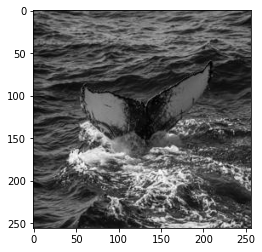

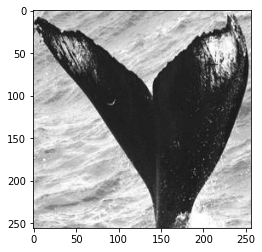

In [ ]:
plt.imshow(train_images[0].reshape(256, 256), cmap = 'gray')
plt.show()
plt.imshow(train_images[1].reshape(256, 256), cmap = 'gray')
plt.show()

In [ ]:
uniques = list(np.unique(train_labels))
datagen = ImageDataGenerator()
params = {'theta':random.randint(-15,15), 'flip_horizontal':True, 'shear':random.randint(-10,10)}
#datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

def get_pairs(batch_size):
  categories = np.random.choice(uniques, size = batch_size)
  pairs = []
  labels = []
  for i in range(batch_size):
    category = categories[i]
    idx_1, idx_2, dif_index = random.choice(np.where(train_labels == category)[0]), random.choice(np.where(train_labels == category)[0]), random.choice(np.where(train_labels != category)[0])
    image_one, image_two, image_three = train_images[idx_1], train_images[idx_2], train_images[dif_index]
    if len(np.where(train_labels == category)[0]) == 1:
      image_two= datagen.apply_transform(image_two, params)
    pairs.append([image_one, image_two])
    pairs.append([image_one, image_three])
    labels.append(1)
    labels.append(0)
  pairs = np.array(pairs)
  labels = np.array(labels)
  return pairs, labels
  
# amount of unique labels in the train set
len(np.unique(train_labels, return_counts = True)[0])

633

In [ ]:
val_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML project/Data/humpback-whale-identification/val_X.csv")
val_data = np.array(val_csv)

path = '/tmp/train_resized_256/'
val_images = []
val_labels = []

for i, img in enumerate(val_data[:,0]):
    f_name = path + img
    val_image = np.array(Image.open(f_name))
    val_images.append(val_image)
    val_labels.append(val_data[i:i+1,1])

val_images = np.reshape(np.array(val_images), (len(val_images), 256, 256, 1)) / 255
val_labels = np.reshape(np.array(val_labels), (len(val_labels), 1))

val_images.shape, val_labels.shape

((1346, 256, 256, 1), (1346, 1))

In [ ]:
random.seed(5)
#creating similar pairs

uniques = np.unique(val_labels) #array of unique labels

similar_X = []
similar_Y = []

for el in uniques:
    index = np.where(val_labels == el)[0] #getting indexes of each unique in val_labels
    for i in range(0,len(index),2):
        pair = []
        image_one = val_images[index[i]]
        image_two = val_images[index[i+1]]
        pair.append(image_one)
        pair.append(image_two)
        similar_X.append(pair)
        similar_Y.append(1)

similar_X = np.array(similar_X)
similar_Y = np.array(similar_Y)

#creating different pairs

different_X = []
different_Y = []

help_list = list(range(int(len(val_images)/2), int(len(val_images)))) #help list to get images from the second half

for i in range(int(len(val_images)/2)): #looping through the first half of the val mages
    pair = []
    image_one = val_images[i]
    random_no = random.choice(help_list)
    image_two = val_images[random_no]
    if val_labels[i] == val_labels[random_no]: #if labels match, goes back to find a new one
        i = i - 1
        pass
    pair.append(image_one)
    pair.append(image_two)
    different_X.append(pair)
    different_Y.append(0) 
    help_list.remove(random_no)

different_X = np.array(different_X)
different_Y = np.array(different_Y)

similar_X.shape, different_X.shape, similar_Y.shape, different_Y.shape

((673, 2, 256, 256, 1), (673, 2, 256, 256, 1), (673,), (673,))

In [ ]:
val_X = np.concatenate((similar_X, different_X))
val_Y = np.asarray(np.reshape(np.concatenate((similar_Y, different_Y)), (len(val_X), 1)))

del similar_X, different_X, similar_Y, different_Y
val_X.shape, val_Y.shape

((1346, 2, 256, 256, 1), (1346, 1))

In [ ]:
del val_images, val_labels

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


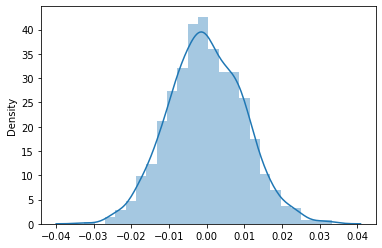

In [ ]:
#code taken from https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb
#"The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01"

def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

weights = initialize_weights((1000,1))
sns.distplot(weights)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


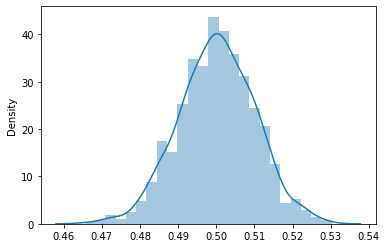

In [ ]:
#code taken from https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb
#"The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01"

def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

bias = initialize_bias((1000,1))
sns.distplot(bias)

In [ ]:
#defining branch and head model

def get_model(input_shape): 
    
    #branch model
    
    seq_model = Sequential()
    
    seq_model.add(Conv2D(64, (6,6), activation='relu', input_shape=input_shape,kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    seq_model.add(MaxPooling2D((2,2)))
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(128, (5,5), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))) 
    seq_model.add(MaxPooling2D((1, 1)))
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
      
    seq_model.add(Conv2D(256, (4,4), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))    
    seq_model.add(MaxPooling2D((2,2))) 
    seq_model.add(Dropout(0.2))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(256, (4,4), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))     
    seq_model.add(MaxPooling2D((2,2)))
    seq_model.add(Dropout(0.2))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(512, (4,4), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))  
    seq_model.add(MaxPooling2D((2,2)))
    seq_model.add(Dropout(0.2))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Dense(1200, activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))  
    seq_model.add(GlobalMaxPooling2D())
    
    seq_model.add(Flatten())
    seq_model.add(Dense(633, activation='sigmoid',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-3)))

    #head model
    
    in1 = Input(input_shape)
    in2 = Input(input_shape)
    
    out_x1 = seq_model(in1)
    out_x2 = seq_model(in2)
    
    euc_dist = Lambda(lambda tensors:tensorflow.keras.backend.abs(tensors[0] - tensors[1]))([out_x1 , out_x2])
    
    outputs = Dense(1, activation = 'sigmoid', bias_initializer=initialize_bias)(euc_dist)
    
    snn = Model(inputs = [in1, in2], outputs = outputs)
    
    return snn

In [ ]:
#create model with necessary input shape, compile

model= get_model((256, 256, 1))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.00001), metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 633)          5259033     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 633)          0           sequential[0][0]      

In [ ]:
epochs = 15000
train_loss_acc = []
val_loss_acc = []
for epoch in range(1, epochs+1):
  print(epoch, end = " ")
  pairs,labels = get_pairs(16)
  history = model.train_on_batch([pairs[:,0], pairs[:,1]], labels)
  train_loss_acc.append(history)
  if epoch % 25 == 0:
    print("\nTrain loss and acc: ", history)
    eval = model.evaluate([val_X[:,0], val_X[:,1]], val_Y, verbose = 0)
    print("Val loss and acc: ", eval)
    val_loss_acc.append(eval)
    if epoch > 25 and val_loss_acc[-2][0] < val_loss_acc[-1][0]:
      model.save('/content/drive/MyDrive/Colab Notebooks/ML project/my_model_2.hdf5')
      model.save_weights('/content/drive/MyDrive/Colab Notebooks/ML project/my_model_weights_2.h5')
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
Train loss and acc:  [0.9100475311279297, 0.5625]
Val loss and acc:  [0.9495433568954468, 0.5]
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 
Train loss and acc:  [0.8918138742446899, 0.5625]
Val loss and acc:  [0.9342514276504517, 0.5]
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 
Train loss and acc:  [0.8761875629425049, 0.53125]
Val loss and acc:  [0.9216463565826416, 0.5]
76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Train loss and acc:  [0.8532214760780334, 0.5625]
Val loss and acc:  [0.9107229709625244, 0.5]
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 
Train loss and acc:  [0.8922590613365173, 0.53125]
Val loss and acc:  [0.9012079238891602, 0.5]
126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 
Train loss and acc:  [0.8

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/ML project/my_model_2.hdf5', custom_objects={'initialize_weights': initialize_weights, 'initialize_bias':initialize_bias})

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ML pildid 256/test_resized_256.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
#creating test images data set
test_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML project/Data/humpback-whale-identification/sample_submission.csv")
test_data = test_csv.values.tolist()
test_image_names = []
for el in test_data:
    test_img_name = el[0]
    test_image_names.append(test_img_name)

In [ ]:
path = '/tmp/test_resized_256/'
test_images = []
for img in test_image_names:
    f_name = path + img
    test_image = np.asarray(Image.open(f_name))
    test_images.append(test_image)

In [ ]:
test_images = np.reshape(np.array(test_images), (len(test_images), 256, 256, 1)) / 255

In [ ]:
import heapq

def generate_training_samples():
  train_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML project/Data/humpback-whale-identification/train_X.csv")
  train_data = np.array(train_csv)

  path = '/tmp/train_resized_256/'
  train_images = []
  train_labels = []

  for i, img in enumerate(train_data[:,0]):
      f_name = path + img
      train_image = np.array(Image.open(f_name))
      train_images.append(train_image)
      train_labels.append(train_data[i:i+1,1])

  #turning train data lists --> reshaped and normalized np.arrays

  train_images = np.reshape(np.array(train_images), (len(train_images), 256, 256, 1)) / 255
  train_labels = np.reshape(np.array(train_labels), (len(train_labels), 1))

  return train_images, train_labels
  
def gen_test(i, start, end, train_images, train_labels, labels, pairs):
  labels = []
  pairs = []
  test_image = test_images[i]
  for k in range(start, end):
    #ix = random.randint(0, len(train_images)-1)
    pair = []
    train_image = train_images[k]
    pair.append(test_image)
    pair.append(train_image)
    labels.append(train_labels[k])
    pairs.append(pair)
  pairs = np.array(pairs)
  labels = np.array(labels)
  return pairs, labels


number_of_elements = 5
all_predictions = []
labels = []
pairs = []
BATCH_SIZE = 64
train_images, train_labels = generate_training_samples()

predictions = []

BATCH_INDICES_PART1 = np.arange(start=0, stop=int(len(train_images)/2), step=BATCH_SIZE)  # row indices of batches
BATCH_INDICES_PART1 = np.append(BATCH_INDICES_PART1, int(len(train_images)/2))  # add final batch_end row

BATCH_INDICES_PART2 = np.arange(start=int(len(train_images)/2), stop=len(train_images), step=BATCH_SIZE)
BATCH_INDICES_PART2 = np.append(BATCH_INDICES_PART2, len(train_images))  # add final batch_end row
  
for pic in range(0, 7960):  
  predict_pair, predict_label = gen_test(pic, 0, int(len(train_images)/2), train_images, train_labels, labels, pairs)
  for index in np.arange(len(BATCH_INDICES_PART1) - 1):
    batch_start = BATCH_INDICES_PART1[index]  # first row of the batch
    batch_end = BATCH_INDICES_PART1[index + 1]  # last row of the batch
    #print((predict_pair[batch_start:batch_end,1]).shape)
    predictions[batch_start:batch_end] = model.predict_on_batch([predict_pair[batch_start:batch_end,0], predict_pair[batch_start:batch_end,1]])


  predict_pair, predict_label = gen_test(pic, int(len(train_images)/2), len(train_images), train_images, train_labels, predict_label, predict_pair)
  for index in np.arange(len(BATCH_INDICES_PART2) - 1):
    batch_start = BATCH_INDICES_PART2[index]  # first row of the batch
    batch_end = BATCH_INDICES_PART2[index + 1]  # last row of the batch
    #print((predict_pair[batch_start:batch_end,1]).shape)
    predictions[batch_start:batch_end] = model.predict_on_batch([predict_pair[(batch_start-int(len(train_images)/2)):(batch_end-int(len(train_images)/2)),0], predict_pair[(batch_start-int(len(train_images)/2)):(batch_end-int(len(train_images)/2)),1]])
  
  #print(predictions)
  five_best_label_index = np.argsort(predictions, axis = 0)[-5:]
  sorted_pred = heapq.nlargest(number_of_elements, predictions)
  all_predictions.append("{} {} {} {} {} {} {} {} {} {}".format(train_labels[five_best_label_index[0][0]][0], sorted_pred[0][0], train_labels[five_best_label_index[1][0]][0], sorted_pred[1][0],
                                                               train_labels[five_best_label_index[2][0]][0], sorted_pred[2][0], train_labels[five_best_label_index[3][0]][0], sorted_pred[3][0],
                                                                train_labels[five_best_label_index[4][0]][0], sorted_pred[4][0]))
  #print(all_predictions)
  print(pic, test_image_names[pic], train_labels[five_best_label_index[0][0]][0], sorted_pred[0][0], train_labels[five_best_label_index[1][0]][0], sorted_pred[1][0],
                                                                train_labels[five_best_label_index[2][0]][0], sorted_pred[2][0], train_labels[five_best_label_index[3][0]][0], sorted_pred[3][0],
                                                                train_labels[five_best_label_index[4][0]][0], sorted_pred[4][0])
  
  #del predict_pair
  #del predict_label
  #del predictions 
  #del five_best_label_index
  #del sorted_pred



submission = pd.DataFrame(
    {'Image': test_image_names[0:7960], 'Id': all_predictions},
    columns = ['Image', 'Id'])
submission.to_csv('submission_baseline.csv', index = False)

0 00028a005.jpg w_4846b27 0.9230128 w_1b7eaad 0.9098638 w_77f9c5f 0.8954694 w_62c78f3 0.89182305 w_c875e45 0.8914028
1 000dcf7d8.jpg w_8da30ad 0.964318 w_7d44896 0.9579144 w_8a1b71c 0.9549542 w_cda3971 0.95393807 w_dc651ad 0.9534867
2 000e7c7df.jpg w_72f3685 0.9397177 w_b3e445e 0.9263324 w_70d0b3c 0.920532 w_1f0cf0a 0.9025664 w_9438119 0.89748055
3 0019c34f4.jpg w_8f0c6ed 0.9274578 w_c2a1bc4 0.9235564 w_581ba42 0.92291135 w_581ba42 0.92231107 w_68eaf36 0.9195473
4 001a4d292.jpg w_d0bfef3 0.9346428 w_71df35a 0.93304396 w_0886321 0.9324011 w_92f4498 0.9249125 w_28c330c 0.9236768
5 00247bc36.jpg w_03670aa 0.96309596 w_d10d0c5 0.9614223 w_cbb15d2 0.9587708 w_01f14e1 0.9523214 w_90abfeb 0.9482256
6 0027089a4.jpg w_3b03149 0.92331415 w_23a388d 0.914033 w_23a388d 0.9112788 w_23a388d 0.9061935 w_fd6a3ad 0.90584224
7 002de4d94.jpg w_3de579a 0.9752397 w_51fc1fc 0.9658613 w_92f4498 0.96361756 w_d9a3c6e 0.9622808 w_0886321 0.96192265
8 002f52f0c.jpg w_85d9229 0.90769476 w_f61b957 0.8994319 w_41d24